# Plot abrupt4xCO2 anomalies and fit different linear responses

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import random as rd
from lmfit import Model
from scipy import optimize
plt.rcParams.update({'figure.max_open_warning': 0})
import importlib
import my_functions as f
importlib.reload(f) # needed to load new changes in my_functions

exp = 'abrupt-4xCO2'

In [4]:
model_anom_names = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/') if f.is_dir() and f.name !='.ipynb_checkpoints']
model_anom_names.sort()

member_dict = {}
for model in model_anom_names:
    anom_exp = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in anom_exp:
        member_dict[model] = f.find_members(model, exp)
member_dict

{'ACCESS-CM2': ['r1i1p1f1'],
 'ACCESS-ESM1-5': ['r1i1p1f1'],
 'AWI-CM-1-1-MR': ['r1i1p1f1'],
 'BCC-CSM2-MR': ['r1i1p1f1'],
 'BCC-ESM1': ['r1i1p1f1'],
 'CAMS-CSM1-0': ['r1i1p1f1', 'r2i1p1f1'],
 'CAS-ESM2-0': ['r1i1p1f1'],
 'CESM2': ['r1i1p1f1'],
 'CESM2-FV2': ['r1i1p1f1'],
 'CESM2-WACCM': ['r1i1p1f1'],
 'CESM2-WACCM-FV2': ['r1i1p1f1'],
 'CIESM': ['r1i1p1f1'],
 'CMCC-CM2-SR5': ['r1i1p1f1'],
 'CNRM-CM6-1': ['r1i1p1f2',
  'r2i1p1f2',
  'r3i1p1f2',
  'r4i1p1f2',
  'r5i1p1f2',
  'r6i1p1f2'],
 'CNRM-CM6-1-HR': ['r1i1p1f2'],
 'CNRM-ESM2-1': ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2'],
 'CanESM5': ['r1i1p1f1', 'r1i1p2f1'],
 'E3SM-1-0': ['r1i1p1f1'],
 'EC-Earth3': ['r3i1p1f1', 'r8i1p1f1'],
 'EC-Earth3-Veg': ['r1i1p1f1'],
 'FGOALS-f3-L': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'FGOALS-g3': ['r1i1p1f1'],
 'FIO-ESM-2-0': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'GFDL-CM4': ['r1i1p1f1'],
 'GFDL-ESM4': ['r1i1p1f1'],
 'GISS-E2-1-G': ['r102i1p1f1', 'r1i1p1f1', 'r1i1p1f3', 'r1i1p3f1', 'r1i1p5f1'],
 'GISS-E2-1-H':

## Define linear temperature models

In [5]:
def exp_part1(t, S1, tau1):
    return S1*(1 - np.exp(-t/tau1))
def exp_part2(t, S2, tau2):
    return S2*(1 - np.exp(-t/tau2))
def exp_part3(t, S3, tau3):
    return S3*(1 - np.exp(-t/tau3))
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

def twoexp_model(t, S1, S2, tau1, tau2):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2)
def threeexp_model(t, S1, S2, S3, tau1, tau2, tau3):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + exp_part3(t, S3, tau3)
def oscillatory_model(t, S1, S2, Sosc1, Sosc2, tau1, tau2, taup, Tq):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + osc_parts(t, Sosc1, Sosc2, taup, Tq)

exp_model1 = Model(exp_part1); exp_model2 = Model(exp_part2); 
twoexp_model = Model(twoexp_model);
twoexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
twoexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
twoexp_model.set_param_hint('tau1', value=4, min=0, max=8)
twoexp_model.set_param_hint('tau2', value=20, min=8, max=1000)

exp_model3 = Model(exp_part3); threeexp_model = Model(threeexp_model);
threeexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
threeexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('S3', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('tau1', value=4, min=0, max=8)
threeexp_model.set_param_hint('tau2', value=20, min=8, max=100)
threeexp_model.set_param_hint('tau3', value=200, min=100, max=1000)

osc_model = Model(osc_parts); expandosc_model = Model(oscillatory_model)
expandosc_model.set_param_hint('S1', value=4, min=0, max=10.0)# guess the same as for two-box model 
expandosc_model.set_param_hint('S2', value=2, min=0, max=10.0)
expandosc_model.set_param_hint('Sosc1', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('Sosc2', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('tau1', value=4, min=0, max=8)
expandosc_model.set_param_hint('tau2', value=20, min=8, max=1000)

# result is sensitive to these choices. 
# Run several initial guesses, and keep result
# only if it gives a better fit than the two-exp
#expandosc_model.set_param_hint('taup', value=600, min=40, max=1000)
#expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)


TaiESM1


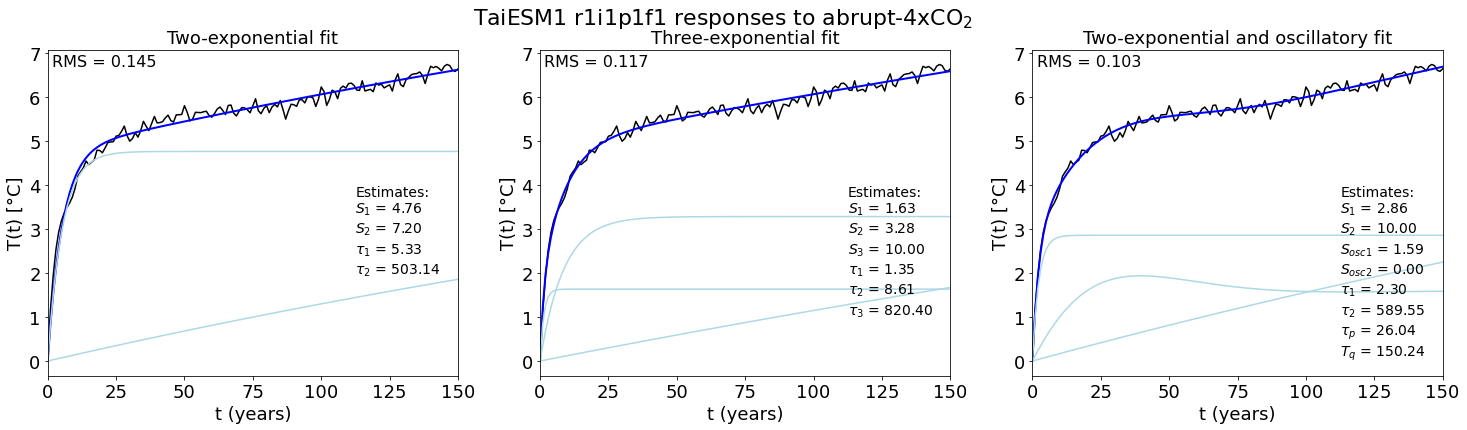

In [6]:
for model in ['TaiESM1']:
#for model in member_dict:
    print(model)
    for member in member_dict[model]:
        data = f.load_anom(model, exp, member, length_restriction = 150)
        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']; years = np.arange(1,150+1)
        if len(deltaT)<150:
            continue
        deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
        
        fig, ax = plt.subplots(ncols = 3, figsize = [25,6]);
        fig.suptitle(model + ' ' + member + ' responses to abrupt-4xCO$_2$',fontsize = 22)
        for axis in ax:
            axis.set_xlabel('t (years)',fontsize = 18)
            axis.set_ylabel('T(t) [°C]',fontsize = 18)
            axis.set_xlim(min(years0),max(years0))
            axis.tick_params(axis='both',labelsize=18)
            axis.plot(years0, deltaT0, color = 'black')

        # plot results of two-exp fit
        result_twoexp = twoexp_model.fit(deltaT0, t=years0)
        twoexp_rms = np.sqrt(np.mean(result_twoexp.residual**2))
        #print(result_twoexp.fit_report())
        ax[0].plot(years0, result_twoexp.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
        ax[0].plot(years0, exp_model1.eval(result_twoexp.params, t=years0), color = 'lightblue')
        ax[0].plot(years0, exp_model2.eval(result_twoexp.params, t=years0), color = 'lightblue')
        ax[0].set_title('Two-exponential fit', fontsize = 18)
        ax[0].text(0.01, 0.95, 'RMS = ' + str(np.round(twoexp_rms,3)), transform=ax[0].transAxes, fontsize = 16)
        partoshow = ['S1', 'S2', 'tau1', 'tau2']
        estimates = [result_twoexp.best_values[par] for par in partoshow]
        textlabels = ['$S_1$', '$S_2$', r'$\tau_1$', r'$\tau_2$']
        ax[0].text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax[0].transAxes)
        for (ind, estimate) in enumerate(estimates):
            ax[0].text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax[0].transAxes)

        
        
        # plot results of three-exp fit
        result_threeexp = threeexp_model.fit(deltaT0, t=years0)
        threeexp_rms = np.sqrt(np.mean(result_threeexp.residual**2))
        ax[1].plot(years0, result_threeexp.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
        ax[1].plot(years0, exp_model1.eval(result_threeexp.params, t=years0), color = 'lightblue')
        ax[1].plot(years0, exp_model2.eval(result_threeexp.params, t=years0), color = 'lightblue')
        ax[1].plot(years0, exp_model3.eval(result_threeexp.params, t=years0), color = 'lightblue')
        ax[1].set_title('Three-exponential fit', fontsize = 18)
        ax[1].text(0.01, 0.95, 'RMS = ' + str(np.round(threeexp_rms,3)), transform=ax[1].transAxes, fontsize = 16)
        
        partoshow = ['S1', 'S2', 'S3', 'tau1', 'tau2', 'tau3']
        estimates = [result_threeexp.best_values[par] for par in partoshow]
        textlabels = ['$S_1$', '$S_2$', '$S_3$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$']
        ax[1].text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax[1].transAxes)
        for (ind, estimate) in enumerate(estimates):
            ax[1].text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax[1].transAxes)
    
            
        # plot results of three-exp fit
        expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
        expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)
        result_expandosc = expandosc_model.fit(deltaT0, t=years0)
        expandosc_rms = np.sqrt(np.mean(result_expandosc.residual**2))
        i=0; #expandosc_rms = 1
        while expandosc_rms > twoexp_rms: # make new guess
            taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
            Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
            expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
            expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
            result_expandosc = expandosc_model.fit(deltaT0, t=years0)
            expandosc_rms = np.sqrt(np.mean(result_expandosc.residual**2))
            partoshow = ['tau1', 'tau2', 'taup', 'Tq']
            estimates = [result_expandosc.best_values[par] for par in partoshow]
            if expandosc_rms < 0.2:
                #ax[2].plot(years0, result_expandosc.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
                print(estimates)
            i =+ 1; print(i)
            
        ax[2].plot(years0, result_expandosc.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
        ax[2].plot(years0, exp_model1.eval(result_expandosc.params, t=years0), color = 'lightblue')
        ax[2].plot(years0, exp_model2.eval(result_expandosc.params, t=years0), color = 'lightblue')
        ax[2].plot(years0, osc_model.eval(result_expandosc.params, t=years0), color = 'lightblue')
        ax[2].set_title('Two-exponential and oscillatory fit', fontsize = 18)
        ax[2].text(0.01, 0.95, 'RMS = ' + str(np.round(expandosc_rms,3)), transform=ax[2].transAxes, fontsize = 16)
        
        partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        estimates = [result_expandosc.best_values[par] for par in partoshow]
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        ax[2].text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax[2].transAxes)
        for (ind, estimate) in enumerate(estimates):
            ax[2].text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax[2].transAxes)
    


## compute ensemble of oscillatory responses

ACCESS-CM2
['tau1=2.96', 'tau2=44.62', 'taup=998.28', 'Tq=97.12', 'S1=3.36', 'S2=3.47', 'Sosc1=0.0', 'Sosc2=0.0']
['tau1=2.65', 'tau2=73.43', 'taup=1000.0', 'Tq=939.77', 'S1=3.17', 'S2=10.0', 'Sosc1=0.0', 'Sosc2=1.2']
['tau1=2.56', 'tau2=39.44', 'taup=290.9', 'Tq=75.23', 'S1=3.09', 'S2=3.67', 'Sosc1=0.0', 'Sosc2=0.0']
['tau1=1.94', 'tau2=37.73', 'taup=22.5', 'Tq=48.54', 'S1=2.59', 'S2=3.84', 'Sosc1=0.32', 'Sosc2=0.0']
['tau1=2.96', 'tau2=44.62', 'taup=998.13', 'Tq=97.12', 'S1=3.36', 'S2=3.47', 'Sosc1=0.0', 'Sosc2=0.0']
['tau1=2.36', 'tau2=38.52', 'taup=900.9', 'Tq=54.94', 'S1=2.97', 'S2=3.71', 'Sosc1=0.05', 'Sosc2=0.0']
['tau1=2.96', 'tau2=44.62', 'taup=999.41', 'Tq=97.12', 'S1=3.36', 'S2=3.47', 'Sosc1=0.0', 'Sosc2=0.0']
['tau1=2.96', 'tau2=44.62', 'taup=999.14', 'Tq=97.12', 'S1=3.36', 'S2=3.47', 'Sosc1=0.0', 'Sosc2=0.0']
['tau1=2.96', 'tau2=44.62', 'taup=998.95', 'Tq=97.12', 'S1=3.36', 'S2=3.47', 'Sosc1=0.0', 'Sosc2=0.0']
['tau1=1.94', 'tau2=37.73', 'taup=22.47', 'Tq=48.54', 'S1=2.59'

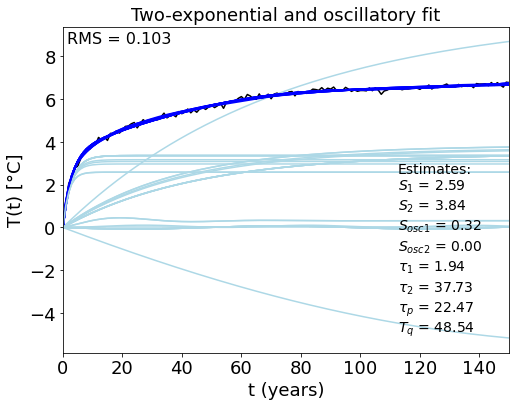

In [8]:
#for model in ['GISS-E2-1-G']:
for model in ['ACCESS-CM2']:
#for model in member_dict:
    print(model)
    for member in member_dict[model]:
        data = f.load_anom(model, exp, member, length_restriction = 150)
        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']; years = np.arange(1,150+1)
        if len(deltaT)<150:
            continue
        deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
        
        fig, ax = plt.subplots(figsize = [8,6]);
        ax.set_xlabel('t (years)',fontsize = 18)
        ax.set_ylabel('T(t) [°C]',fontsize = 18)
        ax.set_xlim(min(years0),max(years0))
        ax.tick_params(axis='both',labelsize=18)
        ax.plot(years0, deltaT0, color = 'black')

        
        # plot results of three-exp fit
        #expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
        #expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)
        #result_expandosc = expandosc_model.fit(deltaT0, t=years0)
        #expandosc_rms = np.sqrt(np.mean(result_expandosc.residual**2))
        nn = 10
        expandosc_rms_list = np.ones(nn)
        for i in range(nn):
            taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
            Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
            expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
            expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
            result_expandosc = expandosc_model.fit(deltaT0, t=years0)
            expandosc_rms_list[i] = np.sqrt(np.mean(result_expandosc.residual**2))
            partoshow = ['tau1', 'tau2', 'taup', 'Tq', 'S1', 'S2', 'Sosc1', 'Sosc2',]
            estimates = [par + '=' + str(np.round(result_expandosc.best_values[par],2)) for par in partoshow]
            if expandosc_rms_list[i] < 0.2:
                ax.plot(years0, result_expandosc.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
                ax.plot(years0, exp_model1.eval(result_expandosc.params, t=years0), color = 'lightblue')
                ax.plot(years0, exp_model2.eval(result_expandosc.params, t=years0), color = 'lightblue')
                ax.plot(years0, osc_model.eval(result_expandosc.params, t=years0), color = 'lightblue')
                print(estimates)
            
        #ax.plot(years0, result_expandosc.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
        ##ax.plot(years0, exp_model1.eval(result_expandosc.params, t=years0), color = 'lightblue')
        #ax.plot(years0, exp_model2.eval(result_expandosc.params, t=years0), color = 'lightblue')
        #ax.plot(years0, osc_model.eval(result_expandosc.params, t=years0), color = 'lightblue')
        ax.set_title('Two-exponential and oscillatory fit', fontsize = 18)
        ax.text(0.01, 0.95, 'RMS = ' + str(np.round(expandosc_rms,3)), transform=ax.transAxes, fontsize = 16)
        
        partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        estimates = [result_expandosc.best_values[par] for par in partoshow]
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        ax.text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax.transAxes)
        for (ind, estimate) in enumerate(estimates):
            ax.text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax.transAxes)


#
# For TaiESM1 we have two different fits which seems to describe the 150 years equally well:
# 1. approx tau = 2.0348818893397915, 18.14307205766397, 999.6768863386172, 273.600132613607
# 2. approx tau = 2.30433031272209, 589.5343624274966, 26.02728344185463, 150.2952115201527
# 1 puts oscillation on slowest mode, 2 puts oscillation on intermediate mode 
# 1 has a negative oscillation, 2 has a positive oscillation
# (resulting in a very(!) strong compensating slow mode)

# similar signs for FIO-ESM-2-0. but for this model
# it could work to have the oscillation on the intermediate scale

# I think an oscillation on 2nd mode is the model that
# most likely has the best physical interpretation,
# since it could be caused by a slowdown of AMOC, which cools the NA